In [1]:
# Set-up
%matplotlib inline
import matplotlib.pyplot as plt

# Built-in python modules
import math
import datetime
import warnings
warnings.filterwarnings(action='ignore')

# Python add-ons
import numpy as np
import pandas as pd
from statsmodels.api import qqplot

# Sandia pvlib-python
import pvlib

# Synthetic
import sys
sys.path.insert(1, '../../')
import src

# 1. Data

In [2]:
FILE = 'bogota-30'

df = pd.read_csv(filepath_or_buffer=f'../data/{FILE}.csv', sep=',', decimal='.', index_col='timestamp', parse_dates=True)

# NaN
df = df.fillna(0)

df.head()

,ghi_wm2,poa_wm2,tmod_c,tamb_c
timestamp,,,,
2020-01-01 00:00:00,0.0,0.0,13.608,26.528
2020-01-01 00:30:00,0.0,0.0,12.301,24.214
2020-01-01 01:00:00,0.0,0.0,11.561,22.762
2020-01-01 01:30:00,0.0,0.0,10.887,21.537
2020-01-01 02:00:00,0.0,0.0,10.652,21.007


# 2. Synthetic Irradiance Data Generation

## 2.1. Clear-Sky Index

According to **(Skartveit and Olseth, 1992)**, the clear-sky index ($k_c$) is the measured irradiance in the plane of array (in this case `poa_wm2` data) normalized by the global irradiance (GHI) under clear sky conditions.

$$
k= \frac{H}{H_{cs}}
\tag{1}
$$

Where $H$ is the observed GHI in the plane of array, and $H_{cs}$ is the clear-sky GHI.

The main benefit is that the losses due to atmosphere are already accounted for as they are encompassed within clear-sky global horizontal irradiance ($H_{cs}$). This means that the losses described by the clear-sky index can be exclusively isolated to the influence of clouds. The clear-sky index, therefore, explains the optical losses associated to clouds.

The value of $k_c$ allows estimating the meteorological conditions of the day according to **(Larrañeta et al., 2015)**. Also, expressing irradiance in terms of $k_c$ is the closest approximation of stationarity with solar irradiance time series, according to (**Bright et al., 2021**). A stationary time series has the same mean, variance and auto-correlation over time.

**Note:** As the presence of clouds is not stationary (except over coarse temporal averages), and the indices represent losses due to clouds, a time series of $k_c$ are not perfectly stationary. That said, it effectively remove all influence of seasons and the daily curve of irradiance (from sunrise and sunset) from the time series (**Bright et al., 2021**).

In [3]:
# Location
latitude = 4.6024
longitude = -74.0674
tz = 'America/Bogota'
altitude = 2624 # [m]

location = pvlib.location.Location(latitude, longitude, tz, altitude)

In [4]:
# Clear-sky irradiance (Hcs)
RESOLUTION = int(pd.Series(df.index.values).diff().median().total_seconds()/60)

# Clear-sky irradiance (Hcs)
hcs = location.get_clearsky(times=pd.date_range(start=df.index[0], end=df.index[-1], freq=f'{RESOLUTION}min', tz=tz),
                            model='ineichen')

hcs.head()

,ghi,dni,dhi
2020-01-01 00:00:00-05:00,0.0,0.0,0.0
2020-01-01 00:30:00-05:00,0.0,0.0,0.0
2020-01-01 01:00:00-05:00,0.0,0.0,0.0
2020-01-01 01:30:00-05:00,0.0,0.0,0.0
2020-01-01 02:00:00-05:00,0.0,0.0,0.0


Same as (**Bright et al., 2021**) described, at sunrise and sunset the values of irradiance are in the order of 0 - 10 W/m2, $k_c$ become very sensitive to discrepancies between clear-sky estimate and measurement. It is common in solar energy engineering to ignore the first 5° of solar elevation.

In [5]:
# Append clear-sky irradiance to main dataframe
df['hcs_wm2'] = hcs['ghi'].values

# Clear-sky index (kc) to main dataframe
df['kc'] = df['poa_wm2'].values / df['hcs_wm2'].values

# Filters
## NaN
df['kc'] = df['kc'].fillna(1)

# Replace kc > 1
df.loc[df['kc'] > 1, 'kc'] = 1

df.head()

,ghi_wm2,poa_wm2,tmod_c,tamb_c,hcs_wm2,kc
timestamp,,,,,,
2020-01-01 00:00:00,0.0,0.0,13.608,26.528,0.0,1.0
2020-01-01 00:30:00,0.0,0.0,12.301,24.214,0.0,1.0
2020-01-01 01:00:00,0.0,0.0,11.561,22.762,0.0,1.0
2020-01-01 01:30:00,0.0,0.0,10.887,21.537,0.0,1.0
2020-01-01 02:00:00,0.0,0.0,10.652,21.007,0.0,1.0


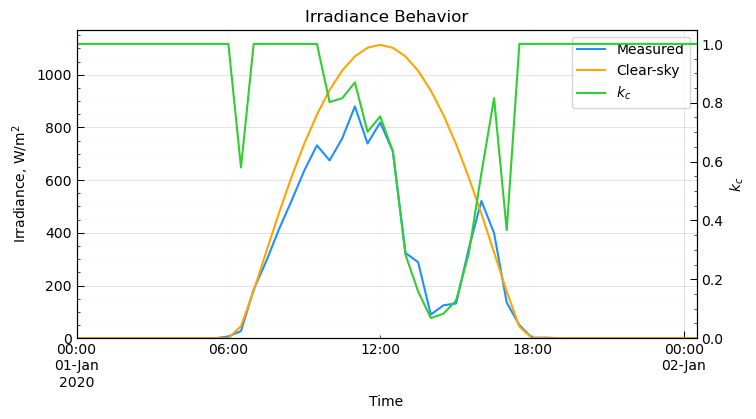

In [6]:
hor = 8
ver = 4
plt.figure(figsize=(hor, ver), dpi=100)

# GHI and Hcs
df['ghi_wm2'][0:50].plot(color='dodgerblue', label='Measured', xlabel='Time', ylabel='Irradiance, W/m$^2$', legend=True)
df['hcs_wm2'][0:50].plot(color='orange', label='Clear-sky', xlabel='Time', ylabel='Irradiance, W/m$^2$', legend=True)

plt.rcParams['axes.axisbelow'] = True

plt.title('Irradiance Behavior')
plt.xlabel('Time')

plt.tick_params(which='major', direction='in', length=5, width=0.75, grid_alpha=0.3)
plt.tick_params(which='minor', direction='in', length=2.5, width=0.5, grid_alpha=0.3)
plt.xticks(rotation=0)
plt.minorticks_on()
plt.ylim(0, None)
plt.xlim(None, None)
plt.grid(True)
plt.grid(visible=True, which='major', color='grey', linestyle='-', linewidth=0.5)
plt.grid(visible=True, which='minor', color='lightgrey', linestyle='-', linewidth=0.3, alpha=0.2)
plt.legend(loc='best', fontsize=9)
plt.tight_layout;

# kc
df['kc'][0:50].plot(color='limegreen', label='$k_c$', secondary_y=True, xlabel='Time', ylabel='$k_c$', legend=True, mark_right=False)

plt.tick_params(which='major', direction='in', length=5, width=0.75, grid_alpha=0.3)
plt.tick_params(which='minor', direction='in', length=2.5, width=0.5, grid_alpha=0.3)
plt.xticks(rotation=0)
plt.minorticks_on()
plt.ylim(0, None)
plt.xlim(None, None)
plt.tight_layout;

## 2.2. `analysis`: Function to extract descriptive statistics from irradiance data

In [7]:
TIMES = [f'{i}:0{j}' if j < 10 else f'{i}:{j}' for i in range(0, 24) for j in range(0, 60, RESOLUTION)]

MONTHS = {'1': 'Jan', '2': 'Feb', '3': 'Mar', '4': 'Apr', '5': 'May', '6': 'Jun',
          '7': 'Jul', '8': 'Aug', '9': 'Sep', '10': 'Oct', '11': 'Nov', '12': 'Dec'}

INVERSE_MONTHS = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
                  'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}

MULTIINDEX = [(i,j) for i in range(0, 24) for j in range(0, 60, RESOLUTION)]

XTICKS = np.arange(start=0, stop=len(TIMES), step=50)
LABELS = [TIMES[i] for i in XTICKS]

In [8]:
# src.utils.analysis function example

# Selecting year and month to extract
YEAR = 2023
MONTH = 1

ANALYSIS = src.utils.analysis(df=df, year=YEAR, month=MONTH, irradiance_column='poa_wm2', resolution=RESOLUTION, plot=False)

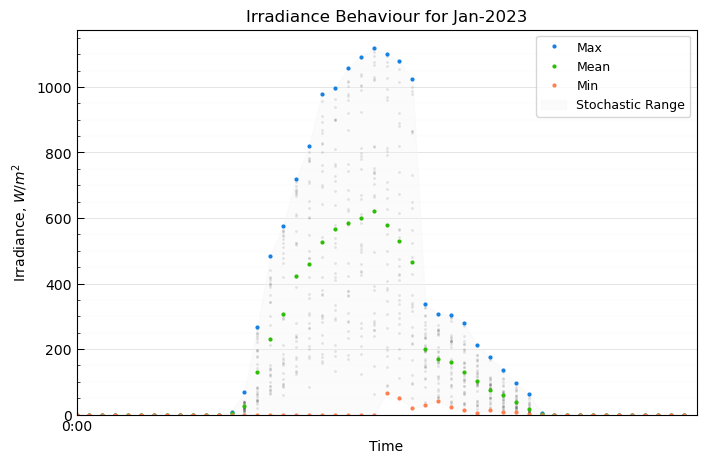

In [9]:
# Array list to store daily irradiance values from irrad_range
aux_irradiance = {'stochastic': {}, 'bootstrap': {}}

# Constants
TIMES = [f'{i}:0{j}' if j < 10 else f'{i}:{j}' for i in range(0, 24) for j in range(0, 60, RESOLUTION)]

MONTHS = {'1': 'Jan', '2': 'Feb', '3': 'Mar', '4': 'Apr', '5': 'May', '6': 'Jun',
          '7': 'Jul', '8': 'Aug', '9': 'Sep', '10': 'Oct', '11': 'Nov', '12': 'Dec'}

# DataFrame filtered by date and between 6:00 to 18:00h range
data = df.loc[(df.index.year == YEAR) & (df.index.month == MONTH)]
aux_data = data.groupby([data.index.hour, data.index.minute])['poa_wm2'].describe()

XTICKS = np.arange(start=0, stop=len(TIMES), step=50)
LABELS = [TIMES[i] for i in XTICKS]

hor = 8
ver = 5
plt.figure(figsize=(hor,ver))

plt.plot(pd.DataFrame(data['poa_wm2'].values.reshape(31, len(TIMES))).T.values, color='black', alpha=0.1, linestyle='', marker='.', markersize=2, fillstyle='none')

plt.plot(aux_data['max'].values, color='#1580E4', marker='.', markersize=4, linestyle='', label='Max')
plt.plot(aux_data['mean'].values, color='#2DBD07', marker='.', markersize=4, linestyle='', label='Mean')
plt.plot(aux_data['min'].values, color='coral', marker='.', markersize=4, linestyle='', label='Min')

plt.fill_between(x=np.arange(len(aux_data)), y1=aux_data['max'], y2=aux_data['min'], color='whitesmoke', alpha=0.35, label='Stochastic Range')

plt.title(f'Irradiance Behaviour for {MONTHS[str(MONTH)]}-{YEAR}')
plt.ylabel('Irradiance, $W/m^2$')
plt.xlabel('Time')

plt.tick_params(which='major', direction='in', length=5, width=0.75, grid_alpha=0.3)
plt.tick_params(which='minor', direction='in', length=2.5, width=0.5, grid_alpha=0.3)
plt.xticks(rotation=0, ticks=XTICKS, labels=LABELS)
plt.minorticks_on()
plt.ylim(0, None)
plt.xlim(0, len(aux_data))
plt.grid(True)
plt.grid(visible=True, which='major', color='grey', linestyle='-', linewidth=0.5)
plt.grid(visible=True, which='minor', color='lightgrey', linestyle='-', linewidth=0.3, alpha=0.2)
plt.tight_layout
plt.legend(loc='best', fontsize=9) # bbox_to_anchor=(1,1)

### 2.2.1. Shapiro-Wilk, Anderson-Darling and Kolmogorov-Smirnov tests

In [10]:
LOOP_YEARS = df.index.year.unique().values
LOOP_MONTHS = df.index.month.unique().values
LOOP_SC = ['sc1', 'sc2', 'sc3', 'sc4', 'sc5']

LOOP_ANALYSIS = {}

for i in LOOP_YEARS:
    for j in LOOP_MONTHS:
        LOOP_ANALYSIS[f'{MONTHS[str(j)]}{i}'] = src.utils.analysis(df=df, year=i, month=j, irradiance_column='poa_wm2', resolution=RESOLUTION, plot=False)

In [11]:
# For high resolution (e.g., 5 min), this cell takes ~10 min to run

DISTRIBUTIONS = pd.DataFrame()

for z in LOOP_ANALYSIS.keys():
    i = int(z[3:7]) # Year
    j = INVERSE_MONTHS[z[0:3]] # Month

    for k in LOOP_SC:
        df_to_check = LOOP_ANALYSIS[z]['bootstrap'][k]

        if (df_to_check.empty != True) and (len(df_to_check) >= 3):
            aux_df = pd.DataFrame(data={'year':i,
                                        'month': j,
                                        'sc': k,
                                        'shapiro_wilk': [src.utils.shapiro_wilk(data=d) for d in df_to_check.T.values],
                                        'anderson_darling': [src.utils.anderson_darling(data=d) for d in df_to_check.T.values],
                                        'lognormal_test': [src.utils.lognormal_test(data=d) for d in df_to_check.T.values]},
                                  index=df_to_check.columns).iloc[TIMES.index('6:00'):TIMES.index('18:00'),:] # 6:15 to 17:45h

            DISTRIBUTIONS = pd.concat([DISTRIBUTIONS, aux_df])

DISTRIBUTIONS.to_csv(f'../distributions/{FILE}/distributions.csv')

DISTRIBUTIONS.describe()

,year,month,shapiro_wilk,anderson_darling,lognormal_test
count,2256.000000,2256.000000,2256.000000,2256.000000,2256.000000
mean,2021.170213,6.042553,0.410696,0.957447,0.218808
std,0.941443,3.787476,0.321035,0.201892,0.321486
min,2020.000000,1.000000,0.000000,0.000000,0.000000
25%,2020.000000,2.000000,0.110000,1.000000,0.000000
50%,2021.000000,6.000000,0.350000,1.000000,0.025000
75%,2022.000000,10.000000,0.670000,1.000000,0.350000
max,2023.000000,12.000000,1.000000,1.000000,1.000000


In [12]:
# Gaussian distribution
complete_gaussian = (len(DISTRIBUTIONS[(DISTRIBUTIONS['shapiro_wilk'] > 0.05) & (DISTRIBUTIONS['anderson_darling'] == 1)]) / len(DISTRIBUTIONS)) * 100
print(f'{np.round(a=complete_gaussian, decimals=2)}% of the total data behaves as a Gaussian distribution according to Shapiro-Wilk and Anderson-Darling tests.')

# Lognormal distribution
complete_lognormal = (len(DISTRIBUTIONS[(DISTRIBUTIONS['lognormal_test'] > 0.05)]) / len(DISTRIBUTIONS)) * 100
print(f'{np.round(a=complete_lognormal, decimals=2)}% of the total data behaves as a lognormal distribution.')

# Gaussian or lognormal
gaussian_or_lognormal = (len(DISTRIBUTIONS[((DISTRIBUTIONS['shapiro_wilk'] > 0.05) & (DISTRIBUTIONS['anderson_darling'] == 1)) | (DISTRIBUTIONS['lognormal_test'] > 0.05)]) / len(DISTRIBUTIONS)) * 100
print(f'{np.round(a=gaussian_or_lognormal, decimals=2)}% of the total data behaves either Gaussian or lognormal distribution.')

79.57% of the total data behaves as a Gaussian distribution according to Shapiro-Wilk and Anderson-Darling tests.
45.17% of the total data behaves as a lognormal distribution.
84.8% of the total data behaves either Gaussian or lognormal distribution.


In [13]:
GROUPED_DISTRIBUTIONS = DISTRIBUTIONS.groupby(by=['year', 'month', 'sc']).mean().round(decimals=2).astype({'anderson_darling': int})
GROUPED_DISTRIBUTIONS.to_csv(f'../distributions/{FILE}/grouped.csv')

GROUPED_DISTRIBUTIONS.describe()

,shapiro_wilk,anderson_darling,lognormal_test
count,94.000000,94.000000,94.000000
mean,0.410638,0.957447,0.218936
std,0.165210,0.202930,0.106574
min,0.120000,0.000000,0.000000
25%,0.300000,1.000000,0.160000
50%,0.390000,1.000000,0.210000
75%,0.490000,1.000000,0.287500
max,1.000000,1.000000,0.480000


In [14]:
GROUPED_DISTRIBUTIONS_FILTERED = GROUPED_DISTRIBUTIONS.drop(GROUPED_DISTRIBUTIONS.loc[(2021, [8, 9, 10, 11], ['sc1', 'sc2', 'sc3', 'sc4', 'sc5'])].index)
GROUPED_DISTRIBUTIONS_FILTERED.describe()

,shapiro_wilk,anderson_darling,lognormal_test
count,89.000000,89.0,89.000000
mean,0.385506,1.0,0.229101
std,0.110690,0.0,0.098542
min,0.120000,1.0,0.050000
25%,0.300000,1.0,0.170000
50%,0.380000,1.0,0.220000
75%,0.480000,1.0,0.290000
max,0.640000,1.0,0.480000


In [15]:
# Gaussian distribution
grouped_gaussian = (len(GROUPED_DISTRIBUTIONS_FILTERED[(GROUPED_DISTRIBUTIONS_FILTERED['shapiro_wilk'] > 0.05) & (GROUPED_DISTRIBUTIONS_FILTERED['anderson_darling'] == 1)]) / len(GROUPED_DISTRIBUTIONS_FILTERED)) * 100
print(f'{np.round(a=grouped_gaussian, decimals=2)}% of the total data behaves as a Gaussian distribution according to Shapiro-Wilk and Anderson-Darling tests.')

# Lognormal distribution
grouped_lognormal = (len(GROUPED_DISTRIBUTIONS_FILTERED[(GROUPED_DISTRIBUTIONS_FILTERED['lognormal_test'] > 0.05)]) / len(GROUPED_DISTRIBUTIONS_FILTERED)) * 100
print(f'{np.round(a=grouped_lognormal, decimals=2)}% of the total data behaves as a lognormal distribution.')

# Gaussian or lognormal
grouped_gaussian_or_lognormal = (len(GROUPED_DISTRIBUTIONS_FILTERED[((GROUPED_DISTRIBUTIONS_FILTERED['shapiro_wilk'] > 0.05) & (GROUPED_DISTRIBUTIONS_FILTERED['anderson_darling'] == 1)) | (GROUPED_DISTRIBUTIONS_FILTERED['lognormal_test'] > 0.05)]) / len(GROUPED_DISTRIBUTIONS_FILTERED)) * 100
print(f'{np.round(a=grouped_gaussian_or_lognormal, decimals=2)}% of the total data behaves either Gaussian or lognormal distribution.')

100.0% of the total data behaves as a Gaussian distribution according to Shapiro-Wilk and Anderson-Darling tests.
97.75% of the total data behaves as a lognormal distribution.
100.0% of the total data behaves either Gaussian or lognormal distribution.


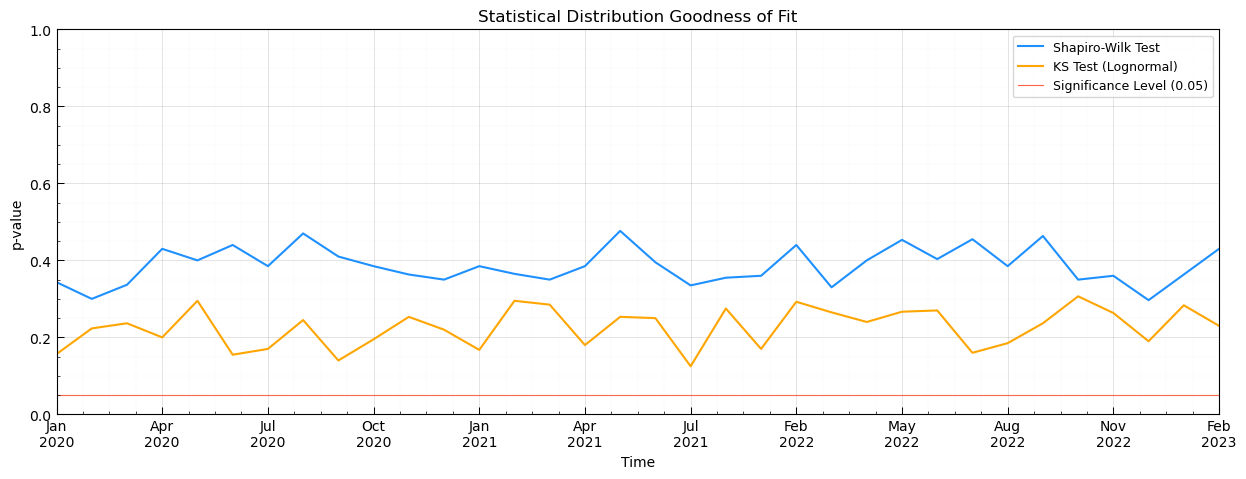

In [16]:
aux_grouped_distributions = GROUPED_DISTRIBUTIONS_FILTERED.groupby(['year', 'month']).mean()
x_axis = [f'{MONTHS[str(i[1])]}\n{i[0]}' for i in aux_grouped_distributions.index]

XTICKS = np.arange(start=0, stop=len(x_axis), step=3)
LABELS = [x_axis[i] for i in XTICKS]

hor = 15
ver = 5
plt.figure(figsize=(hor,ver), dpi=100)

plt.plot(aux_grouped_distributions['shapiro_wilk'].values, color='dodgerblue', label='Shapiro-Wilk Test')
plt.plot(aux_grouped_distributions['lognormal_test'].values, color='orange', label='KS Test (Lognormal)')
plt.axhline(y=0.05, linewidth=0.8, color='tomato', label='Significance Level (0.05)', zorder=0)

plt.title(f'Statistical Distribution Goodness of Fit')
plt.ylabel('p-value')
plt.xlabel('Time')
plt.tick_params(which='major', direction='in', length=5, width=0.75, grid_alpha=0.3)
plt.tick_params(which='minor', direction='in', length=2.5, width=0.5, grid_alpha=0.3)
plt.xticks(rotation=0, ticks=XTICKS, labels=LABELS)
plt.minorticks_on()
plt.ylim(0, 1)
plt.xlim(0, len(aux_grouped_distributions)-1)
plt.grid(True)
plt.grid(visible=True, which='major', color='grey', linestyle='-', linewidth=0.5)
plt.grid(visible=True, which='minor', color='lightgrey', linestyle='-', linewidth=0.3, alpha=0.2)
plt.tight_layout
plt.legend(loc='best', fontsize=9) # bbox_to_anchor=(1,1)

### 2.2.2. Histogram (Gaussian or lognormal distributions)

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

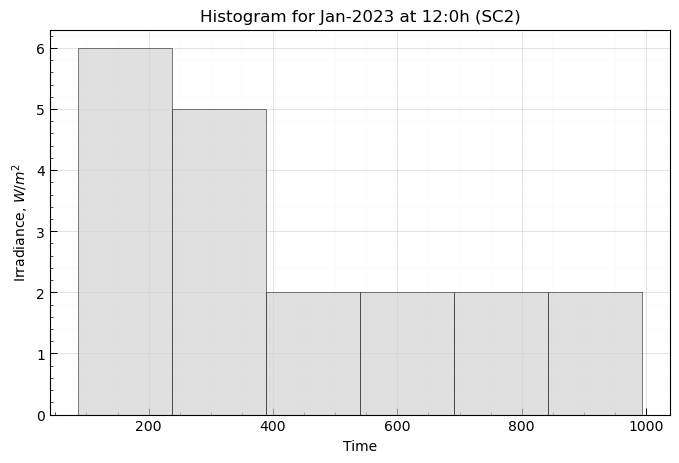

In [17]:
HOUR = 12
MINUTE = 00
SC = 'sc2'

df_to_hist = df[(df.index.year == YEAR) & (df.index.month == MONTH) & (df.index.day.isin(ANALYSIS['bootstrap'][SC].index)) & (df.index.hour == HOUR) & (df.index.minute == MINUTE)]['poa_wm2'].values

hor = 8
ver = 5
plt.figure(figsize=(hor,ver))

plt.hist(x=df_to_hist, bins='auto', color='lightgrey', alpha=0.7, edgecolor='black', linewidth=0.5);

plt.title(f'Histogram for {MONTHS[str(MONTH)]}-{YEAR} at {HOUR}:{MINUTE}h ({str.upper(SC)})')
plt.ylabel('Irradiance, $W/m^2$')
plt.xlabel('Time')
plt.tick_params(which='major', direction='in', length=5, width=0.75, grid_alpha=0.3)
plt.tick_params(which='minor', direction='in', length=2.5, width=0.5, grid_alpha=0.3)
plt.xticks(rotation=0)
plt.minorticks_on()
plt.ylim(0, None)
plt.xlim(None, None)
plt.grid(True)
plt.grid(visible=True, which='major', color='grey', linestyle='-', linewidth=0.5)
plt.grid(visible=True, which='minor', color='lightgrey', linestyle='-', linewidth=0.3, alpha=0.2)
plt.tight_layout
#plt.legend(loc='best', fontsize=9) # bbox_to_anchor=(1,1)

### 2.2.3. QQ-Plots

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

<Figure size 800x500 with 0 Axes>

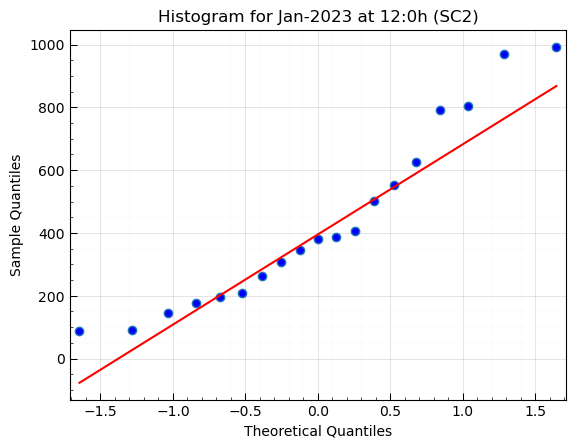

In [18]:
hor = 8
ver = 5
plt.figure(figsize=(hor,ver))

qqplot(df_to_hist, line='q', markerfacecolor='blue')

plt.title(f'Histogram for {MONTHS[str(MONTH)]}-{YEAR} at {HOUR}:{MINUTE}h ({str.upper(SC)})')
#plt.ylabel()
#plt.xlabel()
plt.tick_params(which='major', direction='in', length=5, width=0.75, grid_alpha=0.3)
plt.tick_params(which='minor', direction='in', length=2.5, width=0.5, grid_alpha=0.3)
plt.xticks(rotation=0)
plt.minorticks_on()
plt.ylim(None, None)
plt.xlim(None, None)
plt.grid(True)
plt.grid(visible=True, which='major', color='grey', linestyle='-', linewidth=0.5)
plt.grid(visible=True, which='minor', color='lightgrey', linestyle='-', linewidth=0.3, alpha=0.2)
plt.tight_layout
#plt.legend(loc='best', fontsize=9) # bbox_to_anchor=(1,1)

## 2.3. Methods: `stochastic` and `bootstrap`

In [19]:
SC = 'sc5'
IC = 0.95
RUNS = 5

In [20]:
test_sequential_stochastic = src.methods.sequential(data=df,
                                                            irradiance_column='poa_wm2',
                                                            year=YEAR,
                                                            month=1,
                                                            sky_condition=SC,
                                                            method='stochastic',
                                                            IC=IC,
                                                            resolution=RESOLUTION,
                                                            runs=RUNS)

test_sequential_stochastic.head()

synt1  synt2  synt3  synt4  synt5
hour minute                                   
0    0         0.0    0.0    0.0    0.0    0.0
     30        0.0    0.0    0.0    0.0    0.0
1    0         0.0    0.0    0.0    0.0    0.0
     30        0.0    0.0    0.0    0.0    0.0
2    0         0.0    0.0    0.0    0.0    0.0

In [21]:
test_sequential_bootstrap = src.methods.sequential(data=df,
                                                           irradiance_column='poa_wm2',
                                                           year=YEAR,
                                                           month=1,
                                                           sky_condition=SC,
                                                           method='bootstrap',
                                                           IC=IC,
                                                           resolution=RESOLUTION,
                                                           runs=RUNS)

test_sequential_bootstrap.head()

synt1  synt2  synt3  synt4  synt5
hour minute                                   
0    0         0.0    0.0    0.0    0.0    0.0
     30        0.0    0.0    0.0    0.0    0.0
1    0         0.0    0.0    0.0    0.0    0.0
     30        0.0    0.0    0.0    0.0    0.0
2    0         0.0    0.0    0.0    0.0    0.0

<Figure size 800x500 with 0 Axes>

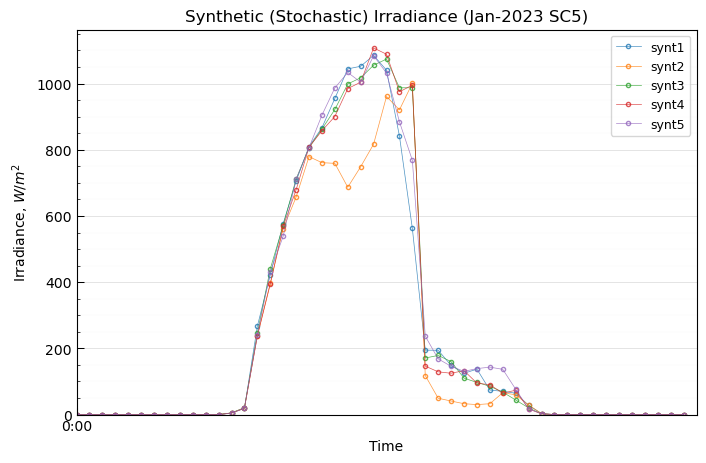

In [22]:
XTICKS = np.arange(start=0, stop=len(TIMES), step=50)
LABELS = [TIMES[i] for i in XTICKS]

hor = 8
ver = 5
plt.figure(figsize=(hor,ver))

test_sequential_stochastic.plot(alpha=0.8, linewidth=0.5, linestyle='-', marker='.', fillstyle='none', figsize=(hor,ver), legend=True)

plt.title(f'Synthetic (Stochastic) Irradiance ({MONTHS[str(MONTH)]}-{YEAR} {str.upper(SC)})')
plt.ylabel('Irradiance, $W/m^2$')
plt.xlabel('Time')
plt.tick_params(which='major', direction='in', length=5, width=0.75, grid_alpha=0.3)
plt.tick_params(which='minor', direction='in', length=2.5, width=0.5, grid_alpha=0.3)
plt.xticks(rotation=0, ticks=XTICKS, labels=LABELS)
plt.minorticks_on()
plt.ylim(0, None)
plt.xlim(0, len(test_sequential_stochastic))
plt.grid(True)
plt.grid(visible=True, which='major', color='grey', linestyle='-', linewidth=0.5)
plt.grid(visible=True, which='minor', color='lightgrey', linestyle='-', linewidth=0.3, alpha=0.2)
plt.tight_layout
plt.legend(loc='best', fontsize=9) # bbox_to_anchor=(1,1)

<Figure size 800x500 with 0 Axes>

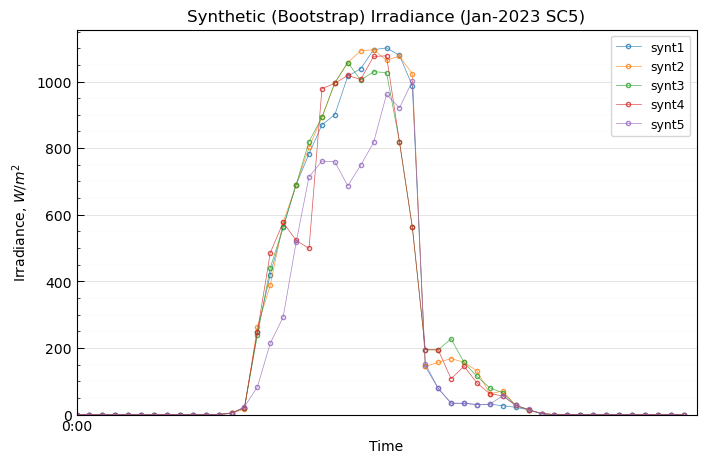

In [23]:
hor = 8
ver = 5
plt.figure(figsize=(hor,ver))

test_sequential_bootstrap.plot(alpha=0.8, linewidth=0.5, linestyle='-', marker='.', fillstyle='none', figsize=(hor,ver), legend=True)

plt.title(f'Synthetic (Bootstrap) Irradiance ({MONTHS[str(MONTH)]}-{YEAR} {str.upper(SC)})')
plt.ylabel('Irradiance, $W/m^2$')
plt.xlabel('Time')
plt.tick_params(which='major', direction='in', length=5, width=0.75, grid_alpha=0.3)
plt.tick_params(which='minor', direction='in', length=2.5, width=0.5, grid_alpha=0.3)
plt.xticks(rotation=0, ticks=XTICKS, labels=LABELS)
plt.minorticks_on()
plt.ylim(0, None)
plt.xlim(0, len(test_sequential_bootstrap))
plt.grid(True)
plt.grid(visible=True, which='major', color='grey', linestyle='-', linewidth=0.5)
plt.grid(visible=True, which='minor', color='lightgrey', linestyle='-', linewidth=0.3, alpha=0.2)
plt.tight_layout
plt.legend(loc='best', fontsize=9) # bbox_to_anchor=(1,1)

# 3. Validations

In [24]:
SYNTHETIC = {'stochastic': {}, 'bootstrap': {}}
IC = 0.95
RUNS = 10

for i in LOOP_YEARS:
    for j in LOOP_MONTHS:
        for k in LOOP_SC:
            # Stochastic
            SYNTHETIC['stochastic'][f'{MONTHS[str(j)]}{i}-{k}'] = src.methods.sequential(data=df,
                                                                                             irradiance_column='poa_wm2',
                                                                                             year=i,
                                                                                             month=j,
                                                                                             sky_condition=k,
                                                                                             method='stochastic',
                                                                                             IC=IC,
                                                                                             resolution=RESOLUTION,
                                                                                             runs=RUNS)
            # Bootstrap
            SYNTHETIC['bootstrap'][f'{MONTHS[str(j)]}{i}-{k}'] = src.methods.sequential(data=df,
                                                                                            irradiance_column='poa_wm2',
                                                                                            year=i,
                                                                                            month=j,
                                                                                            sky_condition=k,
                                                                                            method='bootstrap',
                                                                                            IC=IC,
                                                                                            resolution=RESOLUTION,
                                                                                            runs=RUNS)

## 3.1. Variability metrics

In [25]:
VARIABILITY_METRICS = {'stochastic': {}, 'bootstrap': {}}
RUNS = 100

for m in ['stochastic', 'bootstrap']:
    for z in SYNTHETIC[m].keys():
        i = int(z[3:7]) # Year
        j = INVERSE_MONTHS[z[0:3]] # Month
        k = z[8:11] # Sky condition

        metrics = {'standard_deviation_increments': [[], []],
                    'stability_index': [[], []],
                    'iccdf': [[], []],
                    'variability_index': [[], []]}

        for _ in range(RUNS):
            try:
                aux = LOOP_ANALYSIS[f'{MONTHS[str(j)]}{i}']['bootstrap'][k].T.sample(n=1, axis=1)
                sample1 = aux.values.flatten()
                sample2 = SYNTHETIC[m][f'{MONTHS[str(j)]}{i}-{k}'].sample(n=1, axis=1).values.flatten()

                # Standard deviation of increments (SDI)
                metrics['standard_deviation_increments'][0].append(src.metrics.standard_deviation_increments(data=sample1))
                metrics['standard_deviation_increments'][1].append(src.metrics.standard_deviation_increments(data=sample2))

                # Stability index (SI)
                metrics['stability_index'][0].append(src.metrics.stability_index(data=sample1, threshold=100))
                metrics['stability_index'][1].append(src.metrics.stability_index(data=sample2, threshold=100))

                # Integrated complementary cumulative distribution function (ICCDF)
                metrics['iccdf'][0].append(src.metrics.iccdf(data=sample1))
                metrics['iccdf'][1].append(src.metrics.iccdf(data=sample2))

                # Variability index (VI)
                temp = df.loc[(df.index.year == i) & (df.index.month == j) & (df.index.day == aux.columns[0])]
                metrics['variability_index'][0].append(src.metrics.variability_index(timestamps=temp.index, ghi=sample1, hcs=temp['hcs_wm2'].values).mean())
                metrics['variability_index'][1].append(src.metrics.variability_index(timestamps=temp.index, ghi=sample2, hcs=temp['hcs_wm2'].values).mean())

            except:
                pass

        for _ in metrics.keys():
            metrics[_] = np.mean(metrics[_], axis=1)

        VARIABILITY_METRICS[m][f'{MONTHS[str(j)]}{i}-{k}'] = metrics

In [26]:
metrics_stochastic = pd.DataFrame(VARIABILITY_METRICS['stochastic']).T
metrics_bootstrap = pd.DataFrame(VARIABILITY_METRICS['bootstrap']).T

# Stochastic
pe_stochastic = metrics_stochastic * 0
pe_stochastic['month'] = [INVERSE_MONTHS[i[0:3]] for i in pe_stochastic.index]
pe_stochastic['sc'] = [i[8:11] for i in pe_stochastic.index]

for i in metrics_stochastic.columns:
    pe_stochastic[i] = [src.metrics.wrapper_percentage_error(j) for j in metrics_stochastic[i]]

pe_stochastic = pe_stochastic.fillna(0)

# Bootstrap
pe_bootstrap = metrics_bootstrap * 0
pe_bootstrap['month'] = [INVERSE_MONTHS[i[0:3]] for i in pe_bootstrap.index]
pe_bootstrap['sc'] = [i[8:11] for i in pe_bootstrap.index]

for i in metrics_bootstrap.columns:
    pe_bootstrap[i] = [src.metrics.wrapper_percentage_error(j) for j in metrics_bootstrap[i]]

pe_bootstrap = pe_bootstrap.fillna(0)

In [27]:
# Percentage error monthly average
VM_STOCHASTIC_MONTH = pe_stochastic.groupby(by='month').mean().round(decimals=2)
VM_BOOTSTRAP_MONTH = pe_bootstrap.groupby(by='month').mean().round(decimals=2)

# Percentage error sky condition average
VM_STOCHASTIC_SC = pe_stochastic.groupby(by='sc').mean().round(decimals=2)
VM_BOOTSTRAP_SC = pe_bootstrap.groupby(by='sc').mean().round(decimals=2)

In [28]:
# Download
VM_STOCHASTIC_MONTH.to_csv(f'../metrics/variability/{FILE}/stochastic_month.csv')
VM_BOOTSTRAP_MONTH.to_csv(f'../metrics/variability/{FILE}/bootstrap_month.csv')
VM_STOCHASTIC_SC.to_csv(f'../metrics/variability/{FILE}/stochastic_sc.csv')
VM_BOOTSTRAP_SC.to_csv(f'../metrics/variability/{FILE}/bootstrap_sc.csv')

## 3.2. Comparison of statistical distributions

In [29]:
STATISTICAL_METRICS = {'stochastic': {}, 'bootstrap': {}}
RUNS = 100

for m in ['stochastic', 'bootstrap']:
    for z in SYNTHETIC[m].keys():
        i = int(z[3:7]) # Year
        j = INVERSE_MONTHS[z[0:3]] # Month
        k = z[8:11] # Sky condition

        metrics = {'kolmogorov_smirnov': [],
                   'kullback_leibler_divergence': [],
                   'overlapping_coefficient': []}

        for _ in range(RUNS):
            try:
                sample1 = LOOP_ANALYSIS[f'{MONTHS[str(j)]}{i}']['bootstrap'][k].T.sample(n=1, axis=1).values.flatten()
                sample2 = SYNTHETIC[m][f'{MONTHS[str(j)]}{i}-{k}'].sample(n=1, axis=1).values.flatten()

                # Kolmogorov-Smirnov Test (KS)
                metrics['kolmogorov_smirnov'].append(src.metrics.kolmogorov_smirnov(sample1=sample1, sample2=sample2))

                # Kullback-Leibler Divergence (KLD)
                metrics['kullback_leibler_divergence'].append(src.metrics.kullback_leibler_divergence(sample1=sample1, sample2=sample2))

                # Overlapping coefficient (OVC)
                metrics['overlapping_coefficient'].append(src.metrics.overlapping_coefficient(sample1=sample1, sample2=sample2))

            except:
                pass

        for _ in metrics.keys():
            metrics[_] = np.mean(metrics[_])

        STATISTICAL_METRICS[m][f'{MONTHS[str(j)]}{i}-{k}'] = metrics

In [30]:
ovc = pd.Series([STATISTICAL_METRICS['bootstrap'][i]['overlapping_coefficient'] for i in STATISTICAL_METRICS['bootstrap'].keys()])

In [31]:
# Stochastic
metrics_stochastic = pd.DataFrame(STATISTICAL_METRICS['stochastic']).T
metrics_stochastic['month'] = [INVERSE_MONTHS[i[0:3]] for i in metrics_stochastic.index]
metrics_stochastic['sc'] = [i[8:11] for i in metrics_stochastic.index]
metrics_stochastic = metrics_stochastic.fillna(0)

# Bootstrap
metrics_bootstrap = pd.DataFrame(STATISTICAL_METRICS['bootstrap']).T
metrics_bootstrap['month'] = [INVERSE_MONTHS[i[0:3]] for i in metrics_bootstrap.index]
metrics_bootstrap['sc'] = [i[8:11] for i in metrics_bootstrap.index]
metrics_bootstrap = metrics_bootstrap.fillna(0)

In [32]:
# Monthly average
SM_STOCHASTIC_MONTH = metrics_stochastic.groupby(by='month').mean().round(decimals=2)
SM_BOOTSTRAP_MONTH = metrics_bootstrap.groupby(by='month').mean().round(decimals=2)

# Sky condition average
SM_STOCHASTIC_SC = metrics_stochastic.groupby(by='sc').mean().round(decimals=2)
SM_BOOTSTRAP_SC = metrics_bootstrap.groupby(by='sc').mean().round(decimals=2)

In [33]:
# Download
SM_STOCHASTIC_MONTH.to_csv(f'../metrics/statistical/{FILE}/stochastic_month.csv')
SM_BOOTSTRAP_MONTH.to_csv(f'../metrics/statistical/{FILE}/bootstrap_month.csv')
SM_STOCHASTIC_SC.to_csv(f'../metrics/statistical/{FILE}/stochastic_sc.csv')
SM_BOOTSTRAP_SC.to_csv(f'../metrics/statistical/{FILE}/bootstrap_sc.csv')

## 3.3. Energy production

In [34]:
INVERTER = pvlib.pvsystem.retrieve_sam(name='CECInverter')['ABB__TRIO_50_0_TL_OUTD_US_480__480V_']
MODULE = pvlib.pvsystem.retrieve_sam(name='CECMod')['LG_Electronics_Inc__LG400N2W_A5']
MPS = 16 # Modules per string
SPI = 8 # Strings per inverter
LOSS = 26.9

In [35]:
TMOD = np.mean(df['tmod_c'].loc[(df.index.hour >= 6) & (df.index.hour < 18)])

In [36]:
ENERGY_METRIC = {'stochastic': {}, 'bootstrap': {}}
RUNS = 100

for m in ['stochastic', 'bootstrap']:
    for z in SYNTHETIC[m].keys():
        i = int(z[3:7]) # Year
        j = INVERSE_MONTHS[z[0:3]] # Month
        k = z[8:11] # Sky condition

        metrics = [[], []]

        for _ in range(RUNS):
            try:
                sample1 = LOOP_ANALYSIS[f'{MONTHS[str(j)]}{i}']['bootstrap'][k].T.sample(n=1, axis=1).values.flatten()
                sample2 = SYNTHETIC[m][f'{MONTHS[str(j)]}{i}-{k}'].sample(n=1, axis=1).values.flatten()

                # Energy production
                metrics[0].append(src.metrics.energy(irradiance=sample1, resolution=RESOLUTION, tmod=TMOD, inverter=INVERTER, module=MODULE, mps=MPS, spi=SPI, loss=LOSS))
                metrics[1].append(src.metrics.energy(irradiance=sample2, resolution=RESOLUTION, tmod=TMOD, inverter=INVERTER, module=MODULE, mps=MPS, spi=SPI, loss=LOSS))

            except:
                pass

        ENERGY_METRIC[m][f'{MONTHS[str(j)]}{i}-{k}'] = np.mean(metrics, axis=1)

In [37]:
# Stochastic
metrics_stochastic = pd.DataFrame(ENERGY_METRIC['stochastic'], index=['real', 'synthetic']).T
metrics_stochastic['month'] = [INVERSE_MONTHS[i[0:3]] for i in metrics_stochastic.index]
metrics_stochastic['sc'] = [i[8:11] for i in metrics_stochastic.index]
metrics_stochastic['percentage_error'] = src.metrics.percentage_error(target=metrics_stochastic['real'], predicted=metrics_stochastic['synthetic'])
metrics_stochastic = metrics_stochastic.fillna(0)

# Bootstrap
metrics_bootstrap = pd.DataFrame(ENERGY_METRIC['bootstrap'], index=['real', 'synthetic']).T
metrics_bootstrap['month'] = [INVERSE_MONTHS[i[0:3]] for i in metrics_bootstrap.index]
metrics_bootstrap['sc'] = [i[8:11] for i in metrics_bootstrap.index]
metrics_bootstrap['percentage_error'] = src.metrics.percentage_error(target=metrics_bootstrap['real'], predicted=metrics_bootstrap['synthetic'])
metrics_bootstrap = metrics_bootstrap.fillna(0)

In [38]:
# Percentage error monthly average
EM_STOCHASTIC_MONTH = metrics_stochastic.groupby(by='month').mean().round(decimals=2)
EM_BOOTSTRAP_MONTH = metrics_bootstrap.groupby(by='month').mean().round(decimals=2)

# Percentage error sky condition average
EM_STOCHASTIC_SC = metrics_stochastic.groupby(by='sc').mean().round(decimals=2)
EM_BOOTSTRAP_SC = metrics_bootstrap.groupby(by='sc').mean().round(decimals=2)

In [39]:
# Download
EM_STOCHASTIC_MONTH.to_csv(f'../metrics/energy/{FILE}/stochastic_month.csv')
EM_BOOTSTRAP_MONTH.to_csv(f'../metrics/energy/{FILE}/bootstrap_month.csv')
EM_STOCHASTIC_SC.to_csv(f'../metrics/energy/{FILE}/stochastic_sc.csv')
EM_BOOTSTRAP_SC.to_csv(f'../metrics/energy/{FILE}/bootstrap_sc.csv')

## 3.4. Cumulative density functions (CDF)

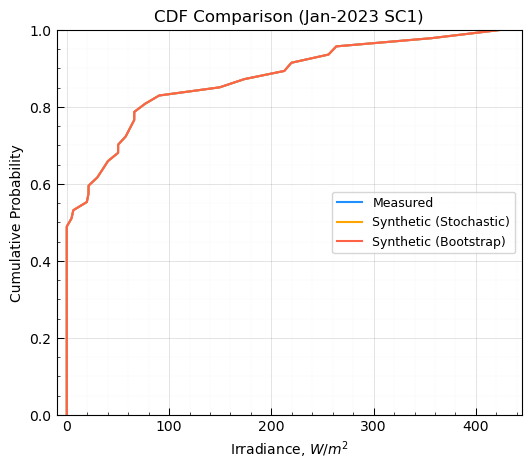

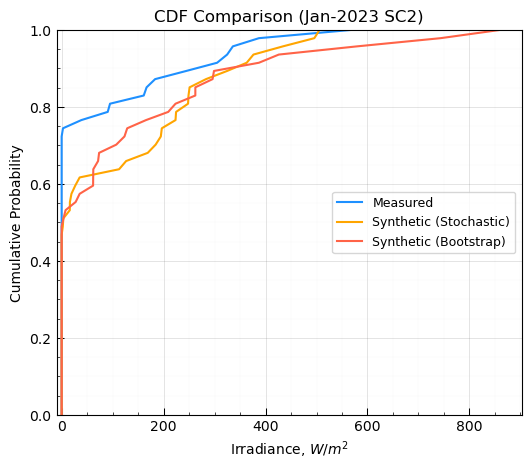

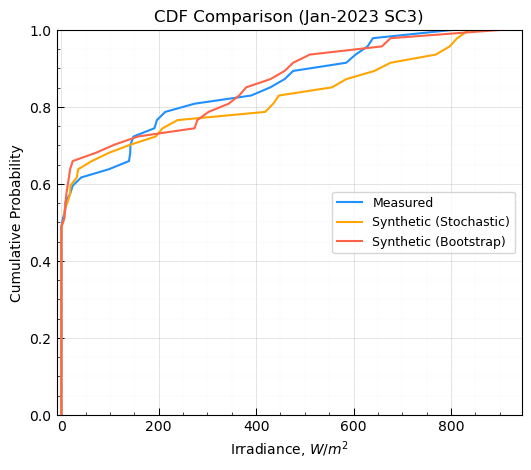

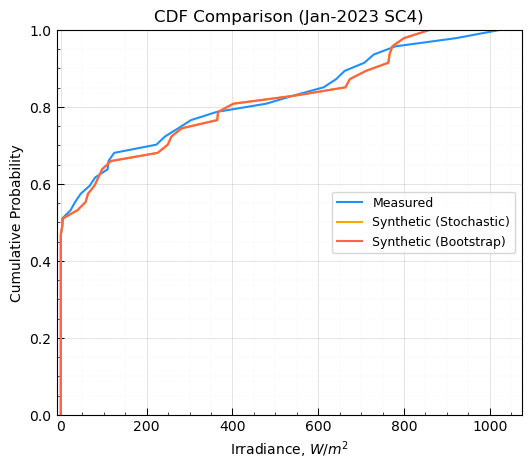

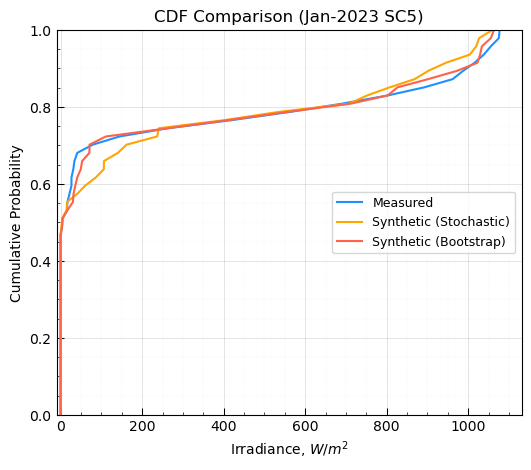

In [40]:
for i in LOOP_SC:
    x, y = src.utils.cdf(data=LOOP_ANALYSIS['Jan2023']['bootstrap'][i].T.sample(n=1, axis=1).iloc[:,0].values)
    xs, ys = src.utils.cdf(data=SYNTHETIC['stochastic'][f'Jan2023-{i}'].sample(n=1, axis=1).iloc[:,0].values)
    xb, yb = src.utils.cdf(data=SYNTHETIC['bootstrap'][f'Jan2023-{i}'].sample(n=1, axis=1).iloc[:,0].values)

    hor = 6
    ver = 5
    plt.figure(figsize=(hor,ver), dpi=100)

    plt.plot(x, y, color='dodgerblue', label='Measured')
    plt.plot(xs, ys, color='orange', label='Synthetic (Stochastic)')
    plt.plot(xb, yb, color='tomato', label='Synthetic (Bootstrap)')

    plt.title(f'CDF Comparison (Jan-2023 {str.upper(i)})')
    plt.ylabel('Cumulative Probability')
    plt.xlabel('Irradiance, $W/m^2$')
    plt.tick_params(which='major', direction='in', length=5, width=0.75, grid_alpha=0.3)
    plt.tick_params(which='minor', direction='in', length=2.5, width=0.5, grid_alpha=0.3)
    plt.xticks(rotation=0)
    plt.minorticks_on()
    plt.ylim(0, 1)
    plt.xlim(-10, None)
    plt.grid(True)
    plt.grid(visible=True, which='major', color='grey', linestyle='-', linewidth=0.5)
    plt.grid(visible=True, which='minor', color='lightgrey', linestyle='-', linewidth=0.3, alpha=0.2)
    plt.tight_layout
    plt.legend(loc='center right', fontsize=9) # bbox_to_anchor=(1,1)

# 4. $T_{amb}$ and $T_{mod}$ Synthetic Data Generation

## 4.1. Data

In [41]:
df['noct_c'] = df['tamb_c'] + (((MODULE['T_NOCT'] - 20)/800) * df['poa_wm2'])

## 4.2. Method: `sequential`

In [42]:
SC = 'sc5'

SYNTHETIC_TAMB = {}
SYNTHETIC_TMOD = {}

for sc in ['sc1', 'sc2', 'sc3', 'sc4', 'sc5']:
    try:
        SYNTHETIC_TAMB[sc] = SYNTHETIC['bootstrap'][f'Jan2020-{sc}'] * 0
        SYNTHETIC_TMOD[sc] = SYNTHETIC['bootstrap'][f'Jan2020-{sc}'] * 0

        data = df.loc[(df.index.year == 2020) & (df.index.month == 1) & (df.index.day.isin(LOOP_ANALYSIS['Jan2020']['bootstrap'][sc].T.columns))]

        for s in SYNTHETIC['bootstrap'][f'Jan2020-{sc}'].columns:
            irradiance = SYNTHETIC['bootstrap'][f'Jan2020-{sc}'][s].values

            tamb = []
            tmod = []

            # Synthetic stochastic temperature
            for i in irradiance:
                irradiance_range = data.loc[(i - i*0.025 <= data['poa_wm2']) & (data['poa_wm2'] <= i + i*0.025)]

                synt_tamb = np.random.normal(loc=irradiance_range['tamb_c'].mean(), scale=irradiance_range['tamb_c'].std())
                synt_tmod = np.random.normal(loc=irradiance_range['tmod_c'].mean(), scale=irradiance_range['tmod_c'].std())

                tamb.append(synt_tamb)
                tmod.append(synt_tmod)

            # Filter synthetic ambient temperature
            new_tamb = []
            for i in range(len(tamb)):
                if math.isnan(tamb[i]) == False:
                    new_tamb.append(tamb[i])
                else:
                    # Previous temperature
                    c = 1
                    t_back = tamb[i-c]

                    while math.isnan(t_back) == True:
                        c += 1
                        t_back = tamb[i-c]

                    # Next temperature
                    c = 1
                    t_front = tamb[i+c]

                    while math.isnan(t_front) == True:
                        c += 1
                        t_front = tamb[i+c]

                    new_tamb.append(np.mean((t_back, t_front)))

            # Filter synthetic module temperature
            new_tmod = []
            for i in range(len(tmod)):
                if math.isnan(tmod[i]) == False:
                    new_tmod.append(tmod[i])
                else:
                    # Previous temperature
                    c = 1
                    t_back = tmod[i-c]

                    while math.isnan(t_back) == True:
                        c += 1
                        t_back = tmod[i-c]

                    # Next temperature
                    c = 1
                    t_front = tmod[i+c]

                    while math.isnan(t_front) == True:
                        c += 1
                        t_front = tmod[i+c]

                    new_tmod.append(np.mean((t_back, t_front)))

            SYNTHETIC_TAMB[sc][s] = tamb
            SYNTHETIC_TMOD[sc][s] = tmod

    except:
        SYNTHETIC_TAMB[sc] = None
        SYNTHETIC_TMOD[sc] = None

In [43]:
# Ambient temperature
synthetic_tamb = []
for i in SYNTHETIC_TAMB.keys():
    try:
        synthetic_tamb = np.concatenate((synthetic_tamb, SYNTHETIC_TAMB[i].to_numpy().T.flatten()))
    except:
        pass

# Module temperature
synthetic_tmod = []
for i in SYNTHETIC_TMOD.keys():
    try:
        synthetic_tmod = np.concatenate((synthetic_tmod, SYNTHETIC_TMOD[i].to_numpy().T.flatten()))
    except:
        pass

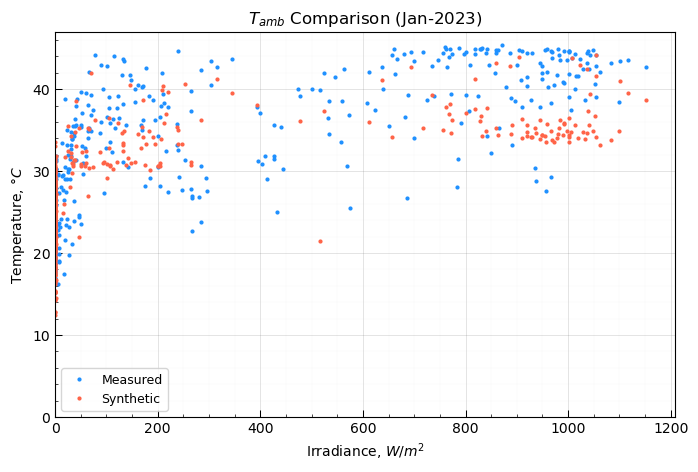

In [44]:
hor = 8
ver = 5
plt.figure(figsize=(hor,ver))

plt.plot(data['poa_wm2'].values, data['tamb_c'].values, linestyle='', marker='o', markerfacecolor='dodgerblue', markeredgecolor='dodgerblue', ms=2, label='Measured')
plt.plot(data['poa_wm2'].values, synthetic_tamb[0:len(data)], linestyle='', marker='o', markerfacecolor='tomato', markeredgecolor='tomato', ms=2, label='Synthetic')
#plt.plot(data['poa_wm2'].values, data['noct_c'].values, linestyle='', marker='o', markerfacecolor='orange', markeredgecolor='orange', ms=2, label='NOCT')

aux_str = '$T_{amb}$'
plt.title(f'{aux_str} Comparison ({MONTHS[str(MONTH)]}-{YEAR})')
plt.ylabel('Temperature, $°C$')
plt.xlabel('Irradiance, $W/m^2$')
plt.tick_params(which='major', direction='in', length=5, width=0.75, grid_alpha=0.3)
plt.tick_params(which='minor', direction='in', length=2.5, width=0.5, grid_alpha=0.3)
plt.xticks(rotation=0)
plt.minorticks_on()
plt.ylim(0, None)
plt.xlim(0, None)
plt.grid(True)
plt.grid(visible=True, which='major', color='grey', linestyle='-', linewidth=0.5)
plt.grid(visible=True, which='minor', color='lightgrey', linestyle='-', linewidth=0.3, alpha=0.2)
plt.tight_layout
plt.legend(loc='best', fontsize=9) # bbox_to_anchor=(1,1)

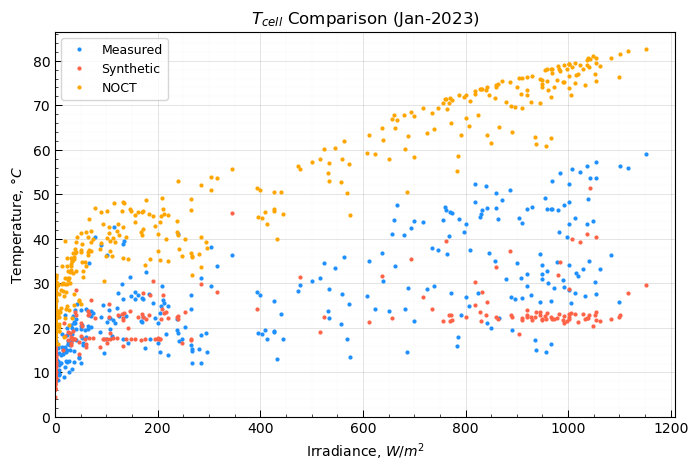

In [45]:
hor = 8
ver = 5
plt.figure(figsize=(hor,ver))

plt.plot(data['poa_wm2'].values, data['tmod_c'].values, linestyle='', marker='o', markerfacecolor='dodgerblue', markeredgecolor='dodgerblue', ms=2, label='Measured')
plt.plot(data['poa_wm2'].values, synthetic_tmod[0:len(data)], linestyle='', marker='o', markerfacecolor='tomato', markeredgecolor='tomato', ms=2, label='Synthetic')
plt.plot(data['poa_wm2'].values, data['noct_c'].values, linestyle='', marker='o', markerfacecolor='orange', markeredgecolor='orange', ms=2, label='NOCT')

aux_str = '$T_{cell}$'
plt.title(f'{aux_str} Comparison ({MONTHS[str(MONTH)]}-{YEAR})')
plt.ylabel('Temperature, $°C$')
plt.xlabel('Irradiance, $W/m^2$')
plt.tick_params(which='major', direction='in', length=5, width=0.75, grid_alpha=0.3)
plt.tick_params(which='minor', direction='in', length=2.5, width=0.5, grid_alpha=0.3)
plt.xticks(rotation=0)
plt.minorticks_on()
plt.ylim(0, None)
plt.xlim(0, None)
plt.grid(True)
plt.grid(visible=True, which='major', color='grey', linestyle='-', linewidth=0.5)
plt.grid(visible=True, which='minor', color='lightgrey', linestyle='-', linewidth=0.3, alpha=0.2)
plt.tight_layout
plt.legend(loc='best', fontsize=9) # bbox_to_anchor=(1,1)